Import libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import geopandas as gpd
from shapely.geometry import Polygon
import geodatasets
import matplotlib.ticker as mticker 
from matplotlib.colors import ListedColormap
from loguru import logger
import sys

In [7]:
import rasterio
import rasterio.mask
import rioxarray as rxr
from matplotlib.dates import MonthLocator, DateFormatter, AutoDateLocator, ConciseDateFormatter
from matplotlib import colormaps
from pathlib import Path
import re
from tqdm.notebook import tqdm

In [8]:
import xarray as xr

In [9]:
import copernicusmarine

In [10]:
from scipy.stats import linregress

In [ ]:
copernicusmarine.subset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["sithick"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="1993-12-01T00:00:00",
  end_datetime="1993-12-01T00:00:00",
  
)

# Thickness

In [11]:
df_1993 = xr.open_dataset("../fraction_area/data/thickness/cmems_mod_arc_phy_my_nextsim_P1M-m_1747297036212_1993.nc")

In [46]:
df_2023 = xr.open_dataset("../fraction_area/data/thickness/cmems_mod_arc_phy_my_nextsim_P1M-m_1747299096281_2023.nc")

In [12]:
df_1993

<xarray.Dataset> Size: 64MB
Dimensions:    (time: 1, latitude: 1336, longitude: 12000)
Coordinates:
  * time       (time) datetime64[ns] 8B 1993-12-01
  * latitude   (latitude) float32 5kB 49.98 50.01 50.04 ... 89.97 90.0 90.03
  * longitude  (longitude) float32 48kB -180.0 -180.0 -179.9 ... 179.9 180.0
Data variables:
    sithick    (time, latitude, longitude) float32 64MB ...
Attributes:
    Conventions:       CF-1.11
    title:             Arctic sea ice reanalysis
    institution:       NERSC, Jahnebakken 3, N-5007 Bergen, Norway
    source:            neXtSIM model fields
    credit:            E.U. Copernicus Marine Service Information (CMEMS)
    contact:           servicedesk.cmems@mercator-ocean.eu
    references:        https://marine.copernicus.eu/
    subset:source:     ARCO data downloaded from the Marine Data Store using ...
    subset:productId:  ARCTIC_MULTIYEAR_PHY_ICE_002_016
    subset:datasetId:  cmems_mod_arc_phy_my_nextsim_P1M-m_202411
    subset:date:       2025-05-15T08:17:16.213Z

In [21]:
thickness = df_1993['sithick']

In [47]:
thickness_new = df_2023['sithick']

In [30]:
thickness_df = thickness.to_dataframe().dropna().reset_index()

In [58]:
thickness_new_df = thickness_new.to_dataframe().dropna().reset_index()

In [33]:
thickness_df.head()

,time,latitude,longitude,sithick
0,1993-12-01,51.209999,-79.800003,0.388275
1,1993-12-01,51.240002,-79.919998,0.324626
2,1993-12-01,51.240002,-79.889999,0.334393
3,1993-12-01,51.240002,-79.860001,0.347744
4,1993-12-01,51.240002,-79.830002,0.393308


In [37]:
thick_50 = thickness_df[(thickness_df['latitude'] > 50) & (thickness_df['latitude'] < 60)].mean()

time         229955
latitude     229955
longitude    229955
sithick      229955
dtype: int64

In [65]:
conditions = [
    (thickness_df['latitude'] > 50) & (thickness_df['latitude'] < 55),
    (thickness_df['latitude'] > 55) & (thickness_df['latitude'] < 60),
    (thickness_df['latitude'] > 60) & (thickness_df['latitude'] < 65),
    (thickness_df['latitude'] > 65) & (thickness_df['latitude'] < 70),
    (thickness_df['latitude'] > 70) & (thickness_df['latitude'] < 75),
    (thickness_df['latitude'] > 75) & (thickness_df['latitude'] < 80),
    (thickness_df['latitude'] > 80) & (thickness_df['latitude'] < 85),
    (thickness_df['latitude'] > 85) & (thickness_df['latitude'] < 90),
    (thickness_df['latitude'] >= 90)
]

cat = [50, 55, 60, 65, 70, 75, 80, 85, 90]

thickness_df['int'] = np.select(conditions, cat, default=np.nan)

In [66]:
thickness_new_df['int'] = np.select(conditions, cat, default=np.nan)

In [68]:
thickness_df.head()

,time,latitude,longitude,sithick,int
0,1993-12-01,51.209999,-79.800003,0.388275,50.0
1,1993-12-01,51.240002,-79.919998,0.324626,50.0
2,1993-12-01,51.240002,-79.889999,0.334393,50.0
3,1993-12-01,51.240002,-79.860001,0.347744,50.0
4,1993-12-01,51.240002,-79.830002,0.393308,50.0


In [60]:
thickness_new_df.head()

,time,latitude,longitude,sithick,int
0,2023-12-01,51.209999,-79.800003,0.476271,50.0
1,2023-12-01,51.240002,-79.919998,0.138498,50.0
2,2023-12-01,51.240002,-79.889999,0.156012,50.0
3,2023-12-01,51.240002,-79.860001,0.172790,50.0
4,2023-12-01,51.240002,-79.830002,0.271498,50.0


In [71]:
mean_1993 = thickness_df.groupby('int')['sithick'].mean()
mean_2023 = thickness_new_df.groupby('int')['sithick'].mean()

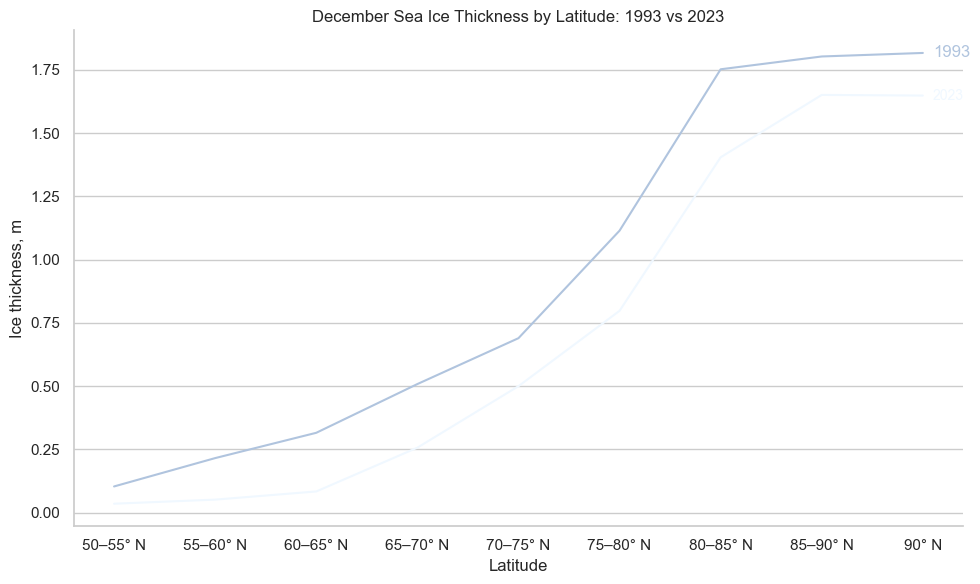

<Figure size 640x480 with 0 Axes>

In [113]:
label_map = {
    50: "50–55° N",
    55: "55–60° N",
    60: "60–65° N",
    65: "65–70° N",
    70: "70–75° N",
    75: "75–80° N",
    80: "80–85° N",
    85: "85–90° N",
    90: "90° N"
}

x_labels = mean_1993.index.map(label_map)

sns.set(style="whitegrid", context="notebook")
plt.figure(figsize=(10, 6))

sns.lineplot(
    x=x_labels,
    y=mean_1993.values,
    label='1993',
    linestyle='-',
    color='lightsteelblue'
    )

sns.lineplot(
    x=x_labels,
    y=mean_2023.values,
    label='2023',
    linestyle='-',
    color='aliceblue'
    )

plt.text(
    x=len(x_labels)-0.9,
    y=mean_1993.values[-1],
    s='1993',
    color='lightsteelblue',
    fontsize=12,
    va='center'
)

plt.text(
    x=len(x_labels)-0.9,
    y=mean_2023.values[-1],
    s='2023',
    color='aliceblue',
    fontsize=10,
    va='center'
)


plt.xlabel('Latitude')
plt.ylabel('Ice thickness, m')
plt.title('December Sea Ice Thickness by Latitude: 1993 vs 2023')
plt.grid(axis='x')
plt.legend().remove()
sns.despine() 

plt.tight_layout()
plt.show()
plt.savefig('sea_ice_thickness_comparison.png', dpi=300, transparent=True)

# Area

In [42]:
df_dec1993 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="1993-12-01T00:00:00",
  end_datetime="1993-12-01T00:00:00",
)

INFO - 2025-05-17T21:31:39Z - Selected dataset version: "202411"
INFO - 2025-05-17T21:31:39Z - Selected dataset part: "default"
INFO - 2025-05-17T21:31:41Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [49]:
def calculate_sea_ice_extent(ds):

    R = 6371000  # radius in m

    lat = ds['latitude'].values
    lon = ds['longitude'].values

    # Calculate cell sizes
    dlat = np.radians(np.diff(lat))
    dlon = np.radians(np.diff(lon))

    dlat = np.append(dlat, dlat[-1])
    dlon = np.append(dlon, dlon[-1])

    area_cells = (R**2) * np.abs(dlat[:, np.newaxis] * dlon[np.newaxis, :] * np.cos(np.radians(lat[:, np.newaxis])))

    area_da = xr.DataArray(area_cells, dims=['latitude', 'longitude'], coords={'latitude': lat, 'longitude': lon})

    siconc = ds['siconc'].isel(time=0)

    ice_coverage = siconc * area_da

    total_ice_area_m2 = ice_coverage.sum(dim=['latitude', 'longitude'], skipna=True).values.item()

    total_ice_area_km2 = total_ice_area_m2 * 1e-6

    return total_ice_area_km2


In [50]:
extent_dec_1993 = calculate_sea_ice_extent(df_dec1993)

In [51]:
extent_dec_1993

11609439.03358356

In [53]:
df_1994 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="1994-12-01T00:00:00",
  end_datetime="1994-12-01T00:00:00",
)

INFO - 2025-05-17T22:45:19Z - Selected dataset version: "202411"
INFO - 2025-05-17T22:45:19Z - Selected dataset part: "default"
INFO - 2025-05-17T22:45:22Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [54]:
extent_dec_1994 = calculate_sea_ice_extent(df_1994)

In [55]:
df_1995 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="1995-12-01T00:00:00",
  end_datetime="1995-12-01T00:00:00",
)

INFO - 2025-05-17T22:48:46Z - Selected dataset version: "202411"
INFO - 2025-05-17T22:48:46Z - Selected dataset part: "default"
INFO - 2025-05-17T22:48:48Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [56]:
extent_dec_1995 = calculate_sea_ice_extent(df_1995)

In [57]:
df_1996 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="1996-12-01T00:00:00",
  end_datetime="1996-12-01T00:00:00",
)

INFO - 2025-05-17T22:52:31Z - Selected dataset version: "202411"
INFO - 2025-05-17T22:52:31Z - Selected dataset part: "default"
INFO - 2025-05-17T22:52:33Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [59]:
extent_dec_1996 = calculate_sea_ice_extent(df_1996)

In [60]:
df_1997 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="1997-12-01T00:00:00",
  end_datetime="1997-12-01T00:00:00",
)

INFO - 2025-05-17T22:54:36Z - Selected dataset version: "202411"
INFO - 2025-05-17T22:54:36Z - Selected dataset part: "default"
INFO - 2025-05-17T22:54:38Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [61]:
extent_dec_1997 = calculate_sea_ice_extent(df_1997)

In [62]:
df_1998 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="1998-12-01T00:00:00",
  end_datetime="1998-12-01T00:00:00",
)

INFO - 2025-05-17T23:00:47Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:00:48Z - Selected dataset part: "default"
INFO - 2025-05-17T23:00:49Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [63]:
extent_dec_1998 = calculate_sea_ice_extent(df_1998)

In [64]:
df_1999 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="1999-12-01T00:00:00",
  end_datetime="1999-12-01T00:00:00",
)

INFO - 2025-05-17T23:03:18Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:03:18Z - Selected dataset part: "default"
INFO - 2025-05-17T23:03:19Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [65]:
extent_dec_1999 = calculate_sea_ice_extent(df_1999)

In [66]:
df_2000 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2000-12-01T00:00:00",
  end_datetime="2000-12-01T00:00:00",
)

INFO - 2025-05-17T23:10:08Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:10:08Z - Selected dataset part: "default"
INFO - 2025-05-17T23:10:10Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [67]:
extent_dec_2000 = calculate_sea_ice_extent(df_2000)

In [68]:
df_2001 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2001-12-01T00:00:00",
  end_datetime="2001-12-01T00:00:00",
)

INFO - 2025-05-17T23:15:25Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:15:25Z - Selected dataset part: "default"
INFO - 2025-05-17T23:15:26Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [69]:
extent_dec_2001 = calculate_sea_ice_extent(df_2001)

In [70]:
df_2002 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2002-12-01T00:00:00",
  end_datetime="2002-12-01T00:00:00",
)

INFO - 2025-05-17T23:17:22Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:17:22Z - Selected dataset part: "default"
INFO - 2025-05-17T23:17:24Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [71]:
extent_dec_2002 = calculate_sea_ice_extent(df_2002)

In [72]:
df_2003 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2003-12-01T00:00:00",
  end_datetime="2003-12-01T00:00:00",
)

INFO - 2025-05-17T23:18:43Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:18:43Z - Selected dataset part: "default"
INFO - 2025-05-17T23:18:45Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [73]:
extent_dec_2003 = calculate_sea_ice_extent(df_2003)

In [74]:
df_2004 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2004-12-01T00:00:00",
  end_datetime="2004-12-01T00:00:00",
)

INFO - 2025-05-17T23:19:46Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:19:46Z - Selected dataset part: "default"
INFO - 2025-05-17T23:19:47Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [75]:
extent_dec_2004 = calculate_sea_ice_extent(df_2004)

In [76]:
df_2005 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2005-12-01T00:00:00",
  end_datetime="2005-12-01T00:00:00",
)

INFO - 2025-05-17T23:20:42Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:20:42Z - Selected dataset part: "default"
INFO - 2025-05-17T23:20:43Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [77]:
extent_dec_2005 = calculate_sea_ice_extent(df_2005)

In [78]:
df_2006 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2006-12-01T00:00:00",
  end_datetime="2006-12-01T00:00:00",
)

INFO - 2025-05-17T23:21:39Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:21:39Z - Selected dataset part: "default"
INFO - 2025-05-17T23:21:41Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekaacheva
Copernicus Marine password: ········


In [79]:
extent_dec_2006 = calculate_sea_ice_extent(df_2006)

In [80]:
df_2007 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2007-12-01T00:00:00",
  end_datetime="2007-12-01T00:00:00",
)

INFO - 2025-05-17T23:22:20Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:22:20Z - Selected dataset part: "default"
INFO - 2025-05-17T23:22:22Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [81]:
extent_dec_2007 = calculate_sea_ice_extent(df_2007)

In [82]:
df_2008 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2008-12-01T00:00:00",
  end_datetime="2008-12-01T00:00:00",
)

INFO - 2025-05-17T23:22:56Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:22:56Z - Selected dataset part: "default"
INFO - 2025-05-17T23:22:58Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [83]:
extent_dec_2008 = calculate_sea_ice_extent(df_2008)

In [84]:
df_2009 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2009-12-01T00:00:00",
  end_datetime="2009-12-01T00:00:00",
)

INFO - 2025-05-17T23:23:41Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:23:41Z - Selected dataset part: "default"
INFO - 2025-05-17T23:23:43Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [85]:
extent_dec_2009 = calculate_sea_ice_extent(df_2009)

In [86]:
df_2010 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2010-12-01T00:00:00",
  end_datetime="2010-12-01T00:00:00",
)

INFO - 2025-05-17T23:24:43Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:24:43Z - Selected dataset part: "default"
INFO - 2025-05-17T23:24:45Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [87]:
extent_dec_2010 = calculate_sea_ice_extent(df_2010)

In [88]:
df_2011 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2011-12-01T00:00:00",
  end_datetime="2011-12-01T00:00:00",
)

INFO - 2025-05-17T23:25:20Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:25:20Z - Selected dataset part: "default"
INFO - 2025-05-17T23:25:22Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [90]:
extent_dec_2011 = calculate_sea_ice_extent(df_2011)

In [91]:
df_2012 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2012-12-01T00:00:00",
  end_datetime="2012-12-01T00:00:00",
)

INFO - 2025-05-17T23:26:07Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:26:07Z - Selected dataset part: "default"
INFO - 2025-05-17T23:26:09Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [92]:
extent_dec_2012 = calculate_sea_ice_extent(df_2012)

In [93]:
df_2013 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2013-12-01T00:00:00",
  end_datetime="2013-12-01T00:00:00",
)

INFO - 2025-05-17T23:26:47Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:26:47Z - Selected dataset part: "default"
INFO - 2025-05-17T23:26:49Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [94]:
extent_dec_2013 = calculate_sea_ice_extent(df_2013)

In [95]:
df_2014 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2014-12-01T00:00:00",
  end_datetime="2014-12-01T00:00:00",
)

INFO - 2025-05-17T23:27:35Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:27:35Z - Selected dataset part: "default"
INFO - 2025-05-17T23:27:36Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [96]:
extent_dec_2014 = calculate_sea_ice_extent(df_2014)

In [97]:
df_2015 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2015-12-01T00:00:00",
  end_datetime="2015-12-01T00:00:00",
)

INFO - 2025-05-17T23:28:16Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:28:16Z - Selected dataset part: "default"
INFO - 2025-05-17T23:28:17Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [98]:
extent_dec_2015 = calculate_sea_ice_extent(df_2015)

In [99]:
df_2016 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2016-12-01T00:00:00",
  end_datetime="2016-12-01T00:00:00",
)

INFO - 2025-05-17T23:29:02Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:29:02Z - Selected dataset part: "default"
INFO - 2025-05-17T23:29:04Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [100]:
extent_dec_2016 = calculate_sea_ice_extent(df_2016)

In [101]:
df_2017 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2017-12-01T00:00:00",
  end_datetime="2017-12-01T00:00:00",
)

INFO - 2025-05-17T23:29:54Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:29:54Z - Selected dataset part: "default"
INFO - 2025-05-17T23:29:56Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [102]:
extent_dec_2017 = calculate_sea_ice_extent(df_2017)

In [103]:
df_2018 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2018-12-01T00:00:00",
  end_datetime="2018-12-01T00:00:00",
)

INFO - 2025-05-17T23:30:31Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:30:31Z - Selected dataset part: "default"
INFO - 2025-05-17T23:30:33Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [104]:
extent_dec_2018 = calculate_sea_ice_extent(df_2018)

In [105]:
df_2019 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2019-12-01T00:00:00",
  end_datetime="2019-12-01T00:00:00",
)

INFO - 2025-05-17T23:31:06Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:31:06Z - Selected dataset part: "default"
INFO - 2025-05-17T23:31:07Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [106]:
extent_dec_2019 = calculate_sea_ice_extent(df_2019)

In [107]:
df_2020 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2020-12-01T00:00:00",
  end_datetime="2020-12-01T00:00:00",
)

INFO - 2025-05-17T23:31:41Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:31:41Z - Selected dataset part: "default"
INFO - 2025-05-17T23:31:43Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [108]:
extent_dec_2020 = calculate_sea_ice_extent(df_2020)

In [109]:
df_2021 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2021-12-01T00:00:00",
  end_datetime="2021-12-01T00:00:00",
)

INFO - 2025-05-17T23:32:27Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:32:27Z - Selected dataset part: "default"
INFO - 2025-05-17T23:32:28Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [110]:
extent_dec_2021 = calculate_sea_ice_extent(df_2021)

In [111]:
df_2022 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2022-12-01T00:00:00",
  end_datetime="2022-12-01T00:00:00",
)

INFO - 2025-05-17T23:33:05Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:33:05Z - Selected dataset part: "default"
INFO - 2025-05-17T23:33:07Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [113]:
extent_dec_2022 = calculate_sea_ice_extent(df_2022)

In [114]:
df_2023 = copernicusmarine.open_dataset(
  dataset_id="cmems_mod_arc_phy_my_nextsim_P1M-m",
  variables=["siconc"],
  minimum_longitude=-180,
  maximum_longitude=179.97000000001367,
  minimum_latitude=49.98,
  maximum_latitude=90.03000000000151,
  start_datetime="2023-12-01T00:00:00",
  end_datetime="2023-12-01T00:00:00",
)

INFO - 2025-05-17T23:33:47Z - Selected dataset version: "202411"
INFO - 2025-05-17T23:33:47Z - Selected dataset part: "default"
INFO - 2025-05-17T23:33:48Z - Downloading Copernicus Marine data requires a Copernicus Marine username and password, sign up for free at: https://data.marine.copernicus.eu/register


Copernicus Marine username: ekalacheva
Copernicus Marine password: ········


In [117]:
extent_dec_2023 = calculate_sea_ice_extent(df_2023)

In [118]:
years = [1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
areas = [extent_dec_1993, extent_dec_1994, extent_dec_1995, 
        extent_dec_1996, extent_dec_1997, extent_dec_1998,
        extent_dec_1999, extent_dec_2000, extent_dec_2001,
        extent_dec_2002, extent_dec_2003, extent_dec_2004,
        extent_dec_2005, extent_dec_2006, extent_dec_2007,
        extent_dec_2008, extent_dec_2009, extent_dec_2010,
        extent_dec_2011, extent_dec_2012, extent_dec_2013, 
        extent_dec_2014, extent_dec_2015, extent_dec_2016,
        extent_dec_2017, extent_dec_2018, extent_dec_2019,
        extent_dec_2020, extent_dec_2021, extent_dec_2022, extent_dec_2023]
df_ice_area = pd.DataFrame({
    'year': years,
    'ice_area_december_million_km2': areas
})
df_ice_area.head()

,year,ice_area_december_million_km2
0,1993,1.160944e+07
1,1994,1.151518e+07
2,1995,1.159795e+07
3,1996,1.152444e+07
4,1997,1.163548e+07


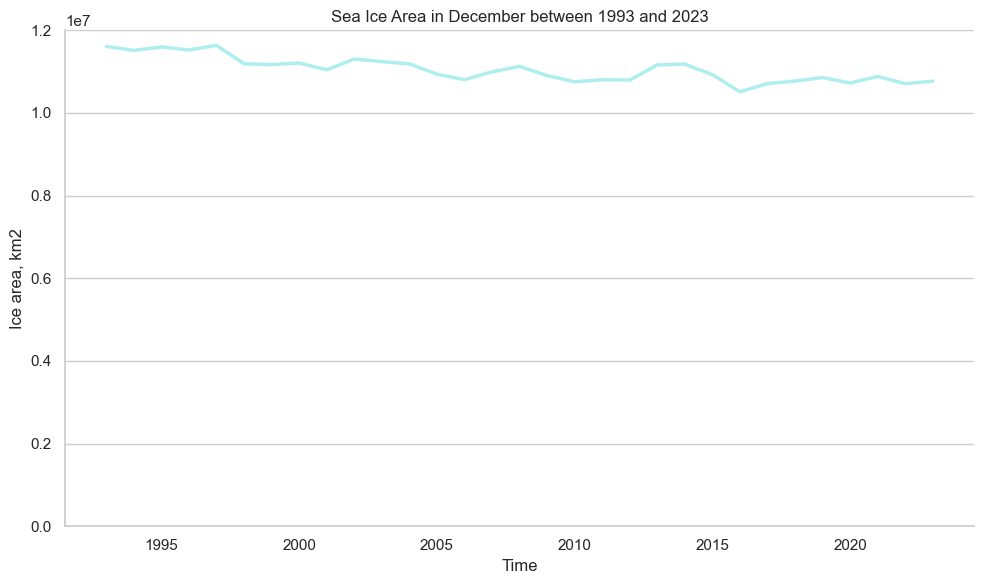

In [126]:
sns.set(style="whitegrid", context="notebook")
plt.figure(figsize=(10, 6))

sns.lineplot(
    x = df_ice_area['year'],
    y = df_ice_area['ice_area_december_million_km2'],
    label='1993',
    linewidth = 2.5,
    linestyle='-',
    color='paleturquoise'
    )

plt.xlabel('Time')
plt.ylabel('Ice area, km2')
plt.ylim(0, 1.2e7)
plt.title('Sea Ice Area in December between 1993 and 2023')
plt.grid(axis='x')
plt.legend().remove()
sns.despine() 

plt.tight_layout()
plt.show()

In [129]:
percent_loss = ((extent_dec_1993 - extent_dec_2023)/ extent_dec_1993) * 100
percent_loss

7.233596524776255